In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import torch
import h5py
#import astroalign as aa
#import sewpy
import re
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import wcs
from astropy.io import fits
from tqdm.notebook import tqdm

sys.path.append('../dancelib')
from residunet import ResidualEncoderUNet
from plotting import plot_images, plot_image_comparison_zoom, plot_precision_recall
from inferring import infer_frames
from analysis import get_recall_prec_fmeas_perthresh, print_metrics_table

In [29]:
plt.rcParams["text.usetex"] = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# You'll need to have SExtractor installed for the analysis portion of the demo
sextractor_path = '/opt/conda/bin/sex'

# Download the data and trained model

##### The simulated M92 data is 160 frames @ 5.25fps = 30s. in total
##### and has size 1024x1024 @ 0.22"/pix = 3.75arcmin²
##### and a *seeing* of 1.27"

In [4]:
data_url = 'https://deepdip.iap.fr/api/v1/item/6631529b7a386bd3dc41d812/download'
data_dir = '../data/'
data_file = 'M92sim.1024x1024x160.fits'
data_path = os.path.join(data_dir,data_file)

# Download the data if it doesn't already exist
print('Path: {}'.format(data_path)) 
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(data_path):
    print('Downloading data...')
    import urllib.request
    urllib.request.urlretrieve(data_url,os.path.join(data_dir,data_file))

Path: ../data/M92sim.1024x1024x160.fits


##### The model was trained with 40,000 12-second simulated video streams of size 256x256

In [5]:
model_url = 'https://deepdip.iap.fr/api/v1/item/66181d157a386bd3dc41d7f6/download'
model_dir = '../model-weights/'
model_file = '1.0m.5.25fps.64frames.n40k.pth'
model_path = os.path.join(model_dir,model_file)

# Download the model if it doesn't already exist
print('Path: {}'.format(model_path))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(model_path):
    print('Downloading model...')
    import urllib.request
    urllib.request.urlretrieve(model_url,os.path.join(model_dir,model_file))

Path: ../model-weights/1.0m.5.25fps.64frames.n40k.pth


#### Set up and load in the model...

In [6]:
deep_supervision = True
input_channels = 64
framerate = 5.25

In [7]:
features_per_stage_template = (32, 64, 125, 256, 320, 320, 512, 1024)
strides_template = (1, 2, 2, 2, 2, 2, 2, 2)
n_blocks_per_stage_template = (2, 2, 2, 2, 2, 2, 2, 2)
n_conv_per_stage_decoder_template = (2, 2, 2, 2, 2, 2, 2, 2)
n_stages = 7

features_per_stage = features_per_stage_template[:n_stages]
strides = strides_template[:n_stages]
n_blocks_per_stage = n_blocks_per_stage_template[:n_stages]
n_conv_per_stage_decoder = n_conv_per_stage_decoder_template[:n_stages-1]
norm_op = torch.nn.InstanceNorm2d 
dropout_op = None
dropout_op_kwargs = None

model = ResidualEncoderUNet(input_channels=input_channels, n_stages=n_stages, features_per_stage=features_per_stage,
                            conv_op=torch.nn.Conv2d, kernel_sizes=3, strides=strides,
                            n_blocks_per_stage=n_blocks_per_stage,
                            num_classes=1,
                            n_conv_per_stage_decoder=n_conv_per_stage_decoder,
                            conv_bias=False,
                            norm_op=norm_op, norm_op_kwargs=None, dropout_op=dropout_op,
                            dropout_op_kwargs=dropout_op_kwargs, nonlin=torch.nn.LeakyReLU,
                            deep_supervision=deep_supervision)

In [8]:
model.load_state_dict(torch.load(model_path, map_location=device)['state_dict'])
model.cuda()
model = model.eval()

#### Load in the data

In [34]:
# Open the FITS file
hdul = fits.open(data_path)

# Access data in the primary HDU
video_data = hdul[0].data.astype(np.float32)

# Access data in the 'GROUNDTRUTH' HDU
groundtruth_image = hdul['GROUNDTRUTH'].data

# Close the HDU list
hdul.close()

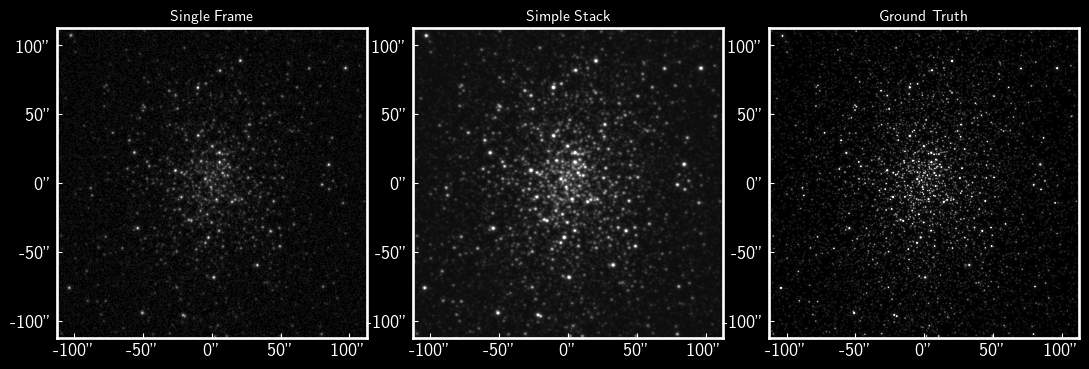

In [35]:
simple_stack = video_data.mean(0)
single_frame = video_data[0]

plot_images([single_frame, simple_stack, groundtruth_image], ['Single Frame', 'Simple Stack', 'Ground Truth'], 0.22, vmax_factors=[0.2, 0.2, 0.02])

# Using the trained model, infer from the video frames what it looks like without atmospheric turbulence and noise

In [11]:
inferred_stack = infer_frames(video_data, model, input_channels=input_channels, tile_size=[256, 256], 
                           tile_overlap=[0.5, 0.5], device=device, deep_supervision=deep_supervision)

100%|██████████| 97/97 [01:10<00:00,  1.37it/s]


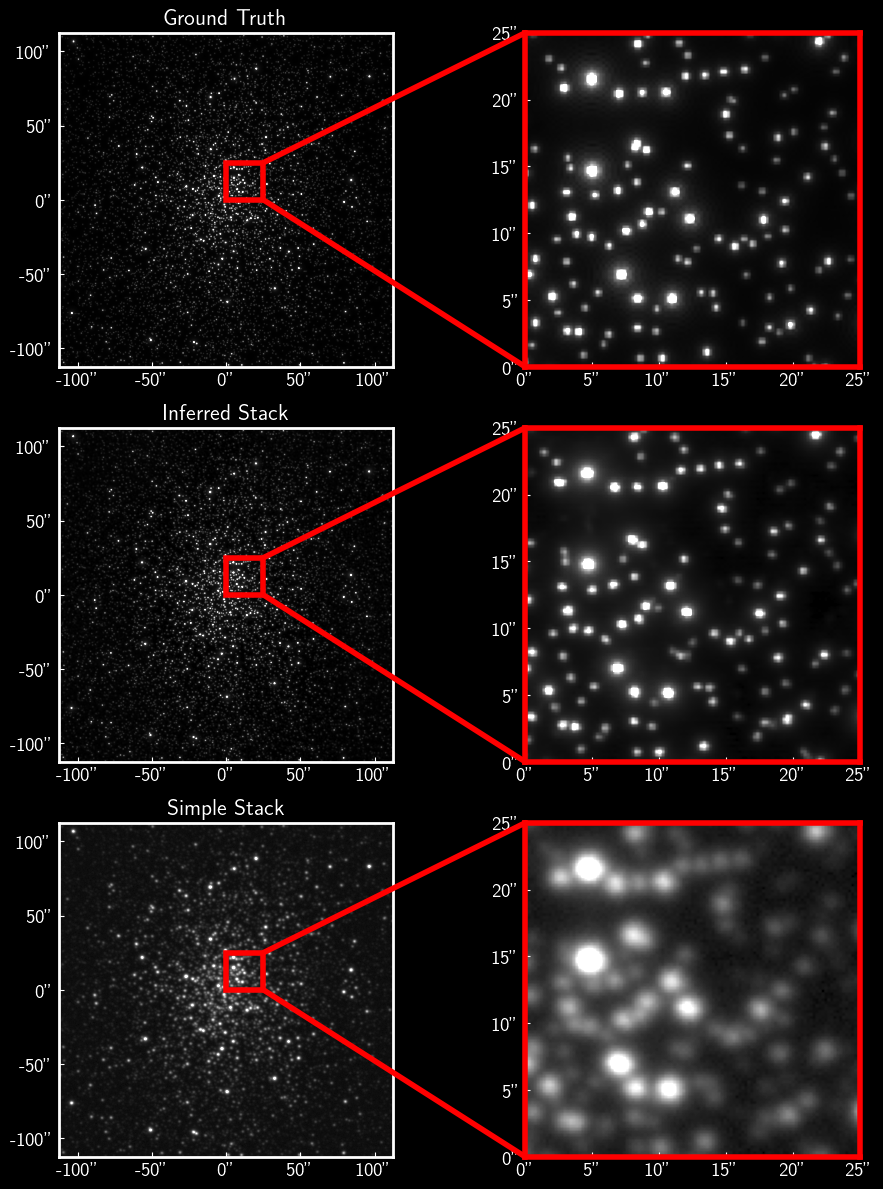

In [36]:
# For plotting, we need to define zoomed-in region coordinates and size [x, y, width, height]
zoom_rect = [0, 0, 25, 25]

plot_image_comparison_zoom([groundtruth_image, inferred_stack, simple_stack], 
                           ['Ground Truth', 'Inferred Stack', 'Simple Stack'], 
                           0.22, vmax_factors=[0.02, 0.02, 0.2], zoom_rect=zoom_rect)

#### Use SExtractor to get the recall and precision of detected stars (compared to ground truth) as a function of detection threshold

In [38]:
thresh_infer, precision_infer, recall_infer, fmeasure_infer = \
get_recall_prec_fmeas_perthresh(inferred_stack, groundtruth_image, min_thresh=13, max_thresh=27, num_thresh=20, verbose=True,
                                sexpath=sextractor_path)

Threshold Selection Progress: 100%|██████████| 20/20 [08:03<00:00, 24.16s/it]


In [37]:
thresh_avgimg, precision_avgimg, recall_avgimg, fmeasure_avgimg = \
get_recall_prec_fmeas_perthresh(simple_stack, groundtruth_image, min_thresh=0.3, max_thresh=2.5, num_thresh=20, verbose=True)

Threshold Selected: 100%|██████████| 20/20 [05:34<00:00, 16.75s/it]


In [42]:
print_metrics_table(thresh_infer, recall_infer, precision_infer, fmeasure_infer, title='Metrics for inferred image')

Metrics for inferred image
------------------------------------------------
Detection                                       
Threshold   Recall      Precision   F-Score     
13.00       91.01       93.64       92.31       
13.74       90.94       93.77       92.33       
14.47       90.95       93.86       92.38       
15.21       90.83       94.04       92.41       
15.95       90.74       94.21       92.44       
16.68       90.64       94.30       92.43       
17.42       90.52       94.51       92.47       
18.16       90.32       94.55       92.38       
18.89       90.21       94.54       92.33       
19.63       89.77       94.45       92.06       
20.37       89.71       94.63       92.11       
21.11       89.65       94.79       92.15       
21.84       89.53       94.85       92.11       
22.58       89.32       95.02       92.08       
23.32       89.22       95.14       92.08       
24.05       88.96       95.20       91.97       
24.79       88.81       95.27       91.93 

In [41]:
print_metrics_table(thresh_avgimg, recall_avgimg, precision_avgimg, fmeasure_avgimg, title='Metrics for averaged image')

Metrics for averaged image
------------------------------------------------
Detection                                       
Threshold   Recall      Precision   F-Score     
0.30        64.45       76.83       70.09       
0.42        64.82       85.58       73.77       
0.53        65.07       90.49       75.70       
0.65        64.66       92.50       76.11       
0.76        63.80       93.89       75.97       
0.88        63.33       94.59       75.86       
0.99        61.85       95.14       74.97       
1.11        60.64       95.28       74.11       
1.23        59.33       95.39       73.15       
1.34        57.05       95.26       71.36       
1.46        55.58       95.49       70.26       
1.57        54.06       95.19       68.95       
1.69        52.47       95.00       67.60       
1.81        50.76       94.73       66.10       
1.92        49.31       94.83       64.88       
2.04        47.97       94.69       63.68       
2.15        46.53       94.63       62.39 

/arc/projects/mlao/dancelib/dancelibpublic/demo/../dancelib/plotting.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


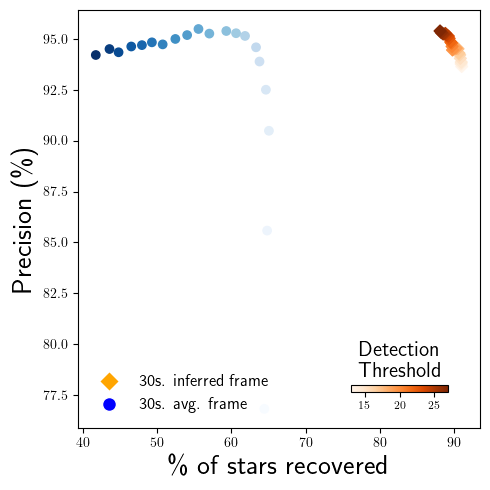

In [49]:
plot_precision_recall(recall_avgimg, precision_avgimg, thresh_avgimg, recall_infer, precision_infer, thresh_infer)